In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D,BatchNormalization,MaxPooling2D

In [ ]:
#steps are required to set up Kaggle API credentials in Colab. Without this setup,
#you won’t be able to use Kaggle commands to download datasets.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d lucassj/dogs-vs-cats-train-validadion-and-evaluation

Dataset URL: https://www.kaggle.com/datasets/lucassj/dogs-vs-cats-train-validadion-and-evaluation
License(s): unknown
100% 1.07G/1.07G [00:54<00:00, 22.0MB/s]
100% 1.07G/1.07G [00:54<00:00, 21.0MB/s]


In [ ]:
#!kaggle datasets list -s "dogs vs cats"  to list existing dataset on cats vs dogs


In [ ]:
import zipfile
import os

# Path to your downloaded zip file (replace 'file-name.zip' with your actual file name)
zip_file = "dogs-vs-cats-train-validadion-and-evaluation.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dogcat_dataset")  # You can specify a directory name


In [ ]:
# use above cell code or direct unzip code below to extract images
#!unzip dogs-vs-cats-train-validadion-and-evaluation.zip -d kaggledataset

In [ ]:
train_dir='/content/dogcat_dataset/train'
val_dir='/content/dogcat_dataset/validation'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,        # Path to the directory containing image data.
    labels="inferred",          # Automatically infer labels from subdirectory names.
    label_mode='int',           # The labels are assigned as integers (0, 1, 2, etc.) based on the alphabetical order of the subfolders.
    class_names=None,           # Class names inferred from directory structure if None; can be manually specified.
    color_mode="rgb",           # Load images in RGB color mode (use "grayscale" for grayscale images).
    batch_size=32,              # Number of samples per batch of data.
    image_size=(256, 256),      # Resize all images to this target size (256x256 pixels in this case).
    validation_split=0.2,       # Reserve 20% of the data for validation.
    subset="training",          # Specify that this dataset is for training. Use "validation" for validation data.
    seed=123                   # Seed for shuffling and ensuring consistent split between training and validation.
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels="inferred",
    label_mode='int',  # Use "categorical" for categorical labels
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123
)


Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [ ]:
for image, label in train_ds.take(1):  # Take one batch from the dataset
    print("Image shape:", image.shape)  # Print the shape of the image tensor
    print("Label shape:", label.shape)  # Print the shape of the label tensor


Image shape: (32, 256, 256, 3)
Label shape: (32,)


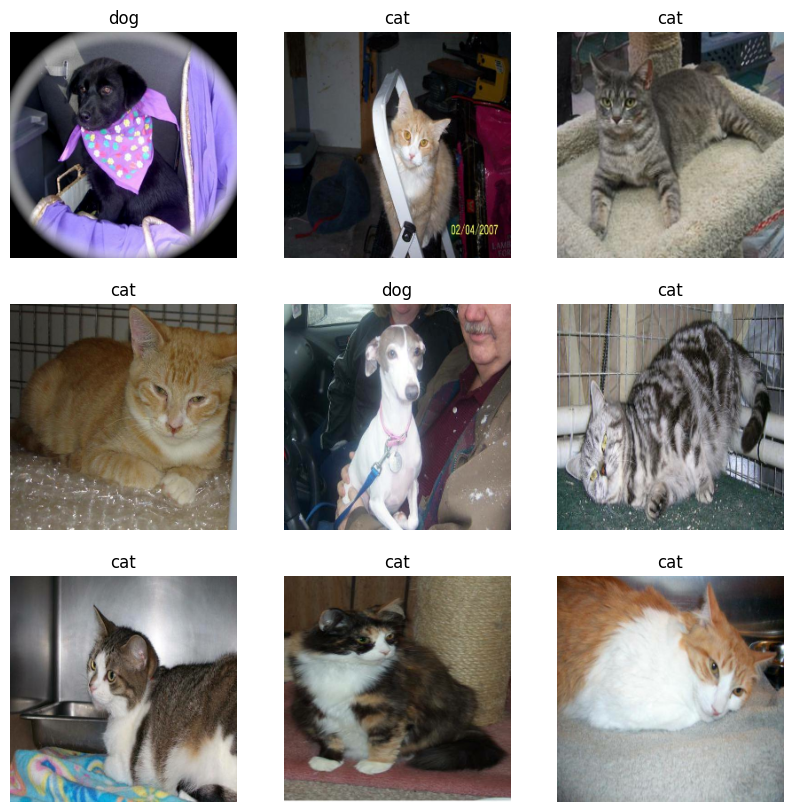

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(train_ds.take(1)))#etrieves the first batch of images and labels

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
plt.show()


In [ ]:
#image scalling
def processes(image,label):
    image=tf.cast(image/255. ,tf.float32)# 256 -->0 to 255 and cast to float
    return image,label

train_ds=train_ds.map(processes)
val_ds=val_ds.map(processes)

In [ ]:
model=Sequential()
#1st convolutional  layer
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
#2st convolutional  layer
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
#2nd convolutional  layer
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#flattern convert to 1D
model.add(Flatten())

#add fully connected neural network
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Early_Stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5,
    restore_best_weights=True,
)
#fit model
history=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks = early_stopping)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 78ms/step - accuracy: 0.5389 - loss: 1.9441 - val_accuracy: 0.4780 - val_loss: 0.6998
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.5873 - loss: 0.6598 - val_accuracy: 0.5720 - val_loss: 1.0028
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.6324 - loss: 0.6360 - val_accuracy: 0.4830 - val_loss: 0.7119
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.6490 - loss: 0.6176 - val_accuracy: 0.6620 - val_loss: 0.5898
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.7080 - loss: 0.5662 - val_accuracy: 0.7640 - val_loss: 0.4978
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.7491 - loss: 0.5039 - val_accuracy: 0.7100 - val_loss: 0.5628
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.7842 - loss: 0.4586 - val_accuracy: 0.6610 - val_loss: 0.6367
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8075 - loss: 0.4097 - 

In [ ]:
validation_loss, validation_accuracy = model.evaluate(val_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7701 - loss: 0.4837
Validation Loss: 0.4977908730506897
Validation Accuracy: 0.7639999985694885


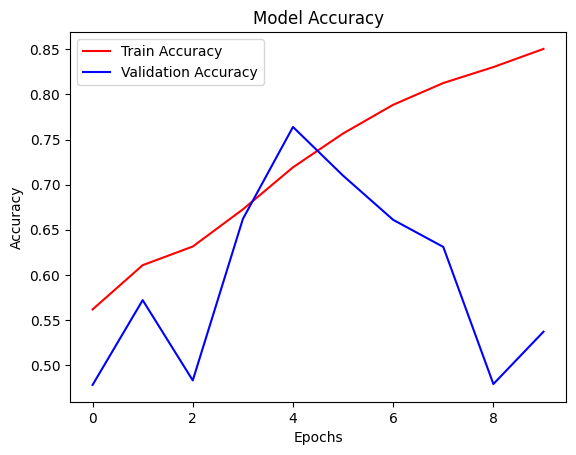

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


In [ ]:
for idx, class_name in enumerate(val_ds.class_names):
    print(f"Class {idx}: {class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


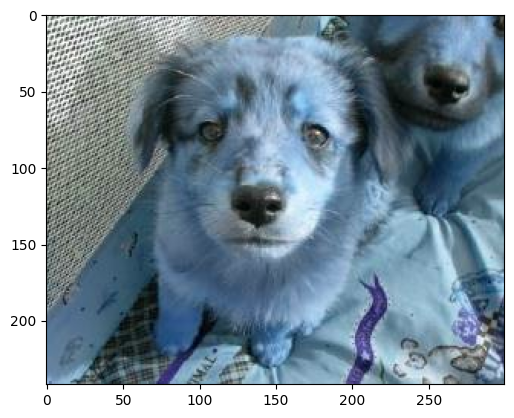

In [ ]:
#predict on new data

import cv2
test_img=cv2.imread('/content/dogcat_dataset/evaluation/dog/175.jpg')
plt.imshow(test_img)
test_img=cv2.resize(test_img,(256,256))
test_input=test_img.reshape(1,256,256,3)
output = model.predict(test_input)

In [ ]:
print(output)

[[1.]]
